<a href="https://colab.research.google.com/github/yesyell/DA_School_1/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EA%B3%BC%ED%95%99%20%EB%B0%A9%EB%B2%95%EB%A1%A0/%EB%A7%88%EC%BC%80%ED%8C%85_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the provided dataset again
cohort_data = pd.read_excel('cohort_test.xlsx')

# Display the first few rows of the dataset
cohort_data.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [2]:
# 1. 주문 날짜를 기반으로 주문 월 생성
cohort_data['OrderPeriod'] = cohort_data['OrderDate'].apply(lambda x: x.strftime('%Y-%m'))
cohort_data.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


In [3]:
# 2. 각 사용자의 첫 주문 월을 생성
cohort_data.set_index('UserId', inplace=True)
cohort_data['CohortGroup'] = cohort_data.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
cohort_data.reset_index(inplace=True)
cohort_data.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


In [4]:
import numpy as np

# 3. CohortGroup과 OrderPeriod를 기반으로 데이터 집계
grouped = cohort_data.groupby(['CohortGroup', 'OrderPeriod'])
cohorts = grouped.agg({
    'UserId': pd.Series.nunique,
    'OrderId': pd.Series.nunique,
    'TotalCharges': np.sum
})
cohorts.rename(columns={'UserId': 'TotalUsers', 'OrderId': 'TotalOrders'}, inplace=True)
cohorts

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2009-01     2009-01              22           30     1850.2550
            2009-02               8           25     1351.0650
            2009-03              10           26     1357.3600
            2009-04               9           28     1604.5000
            2009-05              10           26     1575.6250
...                             ...          ...           ...
2010-01     2010-02              50          101     8453.1039
            2010-03              26           31     2238.6461
2010-02     2010-02             100          139     7374.7108
            2010-03              19           19      945.9633
2010-03     2010-03              24           26     1099.5471

[119 rows x 3 columns]

In [5]:
# 4. 코호트 기간(CohortPeriod) 계산
def cohort_period(df):
    """코호트 기간을 계산하는 함수"""
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts

<ipython-input-5-103f2fd1c710>:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cohorts = cohorts.groupby(level=0).apply(cohort_period)


TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01              22           30     1850.2550             1
            2009-02               8           25     1351.0650             2
            2009-03              10           26     1357.3600             3
            2009-04               9           28     1604.5000             4
            2009-05              10           26     1575.6250             5
...                             ...          ...           ...           ...
2010-01     2010-02              50          101     8453.1039             2
            2010-03              26           31     2238.6461             3
2010-02     2010-02             100          139     7374.7108             1
            2010-03              19           19      945.9633             2
2010-03     2010-03              24           26     1099.5471             1

[119 rows x 4 columns]

In [6]:
# 5. 사용자 잔존율 계산
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
cohort_group_size

CohortGroup
2009-01     22
2009-02     15
2009-03     13
2009-04     39
2009-05     50
2009-06     32
2009-07     50
2009-08     31
2009-09     37
2009-10     54
2009-11    130
2009-12     65
2010-01     95
2010-02    100
2010-03     24
Name: TotalUsers, dtype: int64

In [7]:
user_retention

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03
OrderPeriod,,,,,,,,,,,,,,,
2009-01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-02,0.363636,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03,0.454545,0.200000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04,0.409091,0.333333,0.307692,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05,0.454545,0.066667,0.384615,0.333333,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06,0.363636,0.266667,0.307692,0.256410,0.26,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07,0.363636,0.266667,0.076923,0.333333,0.24,0.46875,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,0.318182,0.266667,0.153846,0.153846,0.10,0.28125,0.46,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,0.318182,0.333333,0.153846,0.179487,0.08,0.18750,0.26,0.354839,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.6 MB/s eta 0:00:00


Text(0, 0.5, '코호트별 구매 비율')

<Figure size 1000x500 with 0 Axes>

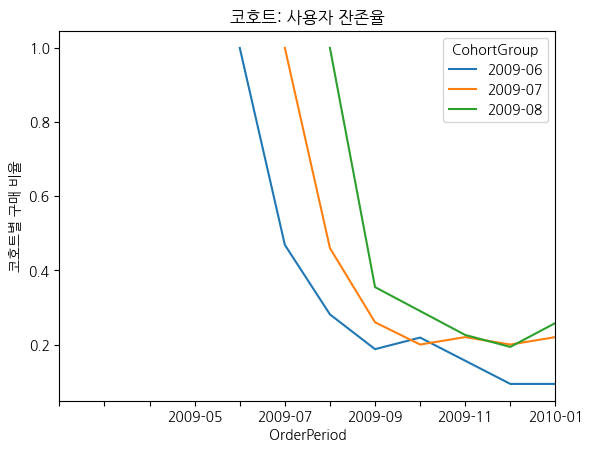

In [9]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10,5))
user_retention[['2009-06', '2009-07', '2009-08']].plot()
plt.title('코호트: 사용자 잔존율')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('코호트별 구매 비율')

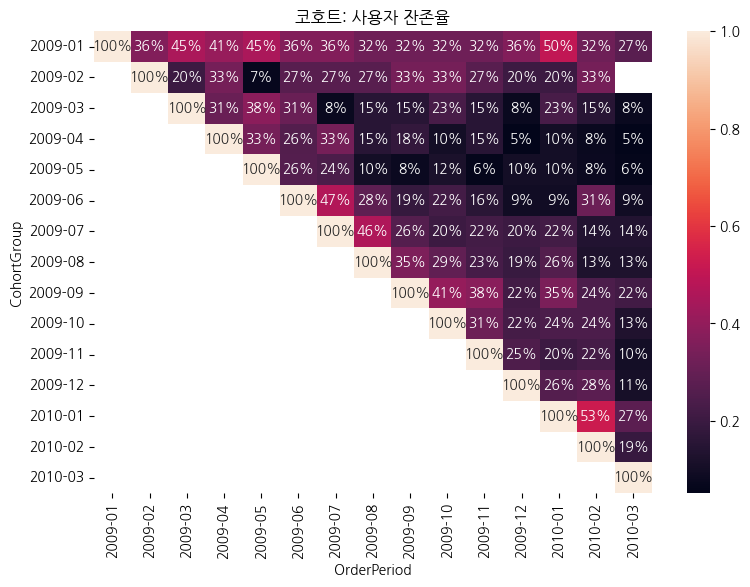

In [10]:
import seaborn as sns

# 히트맵 시각화
plt.figure(figsize=(9, 6))
plt.title('코호트: 사용자 잔존율')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

## CLV 분석

고객 생애 가치 (CLV)란?

- 고객 생애 가치는 고객이 전체 고객 생애 주기 동안 기업에 가져다주는 총 이익을 예측하는 지표입니다. 이 값은 고객을 유치하고 유지하는 데 드는 비용과 비교하여 마케팅 효율성을 평가하는 데 유용합니다.

* `CLV = 평균 구매 금액 × 평균 구매 빈도 × 평균 고객 수명`


평균 구매 금액:

- 모든 주문들의 총 금액을 주문의 총 수로 나눠서 계산합니다.
* 총 구매금액 / 주문수

평균 구매 빈도:

- 주문의 총 수를 고유한 고객 수로 나눠서 계산합니다. 이 값은 평균적으로 한 고객이 얼마나 자주 주문하는지를 나타냅니다.

* 주문수 / 전체고객수

평균 고객 수명:

* 이 값은 고객이 얼마나 오랜 기간동안 서비스나 제품을 이용하는지를 나타냅니다. 여기서는 간단하게 데이터의 최초 주문 날짜와 마지막 주문 날짜의 차이를 사용하여 계산하였습니다.

In [11]:
# 필요한 컬럼만 선택
df = cohort_data[['UserId', 'OrderDate', 'OrderId', 'TotalCharges']]

# 중복 제거
df = df.drop_duplicates()

# 1. 평균 구매 금액 계산
avg_purchase_amount = df['TotalCharges'].sum() / df['OrderId'].nunique()

# 2. 평균 구매 빈도 계산
avg_purchase_frequency = df['OrderId'].nunique() / df['UserId'].nunique()

# 3. 평균 고객 수명 계산 (데이터의 시간 범위를 기준으로 함)
avg_customer_lifetime = (df['OrderDate'].max() - df['OrderDate'].min()).days

# 4. CLV 계산
CLV = avg_purchase_amount * avg_purchase_frequency * avg_customer_lifetime
CLV

97757.2275322325

## 평균 주문금액 분석

In [12]:
# 평균 주문 금액 분석

# 각 날짜별로 주문된 총 금액과 주문 수를 집계
avg_order_value = df.groupby('OrderDate').agg({'TotalCharges': 'sum', 'OrderId': 'count'})

# 평균 주문 금액 계산
avg_order_value['AvgOrderValue'] = avg_order_value['TotalCharges'] / avg_order_value['OrderId']
avg_order_value

,TotalCharges,OrderId,AvgOrderValue
OrderDate,,,
2009-01-06,163.1000,4,40.775000
2009-01-11,50.6700,1,50.670000
2009-01-12,87.6300,1,87.630000
2009-01-13,218.8300,4,54.707500
2009-01-14,208.2500,3,69.416667
...,...,...,...
2010-03-05,1791.7728,23,77.903165
2010-03-06,163.8500,4,40.962500
2010-03-07,648.9054,13,49.915800


특정 시기에 급격한 변동이 있는 경우, 해당 시기의 마케팅 활동, 제품 라인업 변경, 경쟁사의 활동 등 외부 요인을 고려하여 분석할 필요가 있습니다.

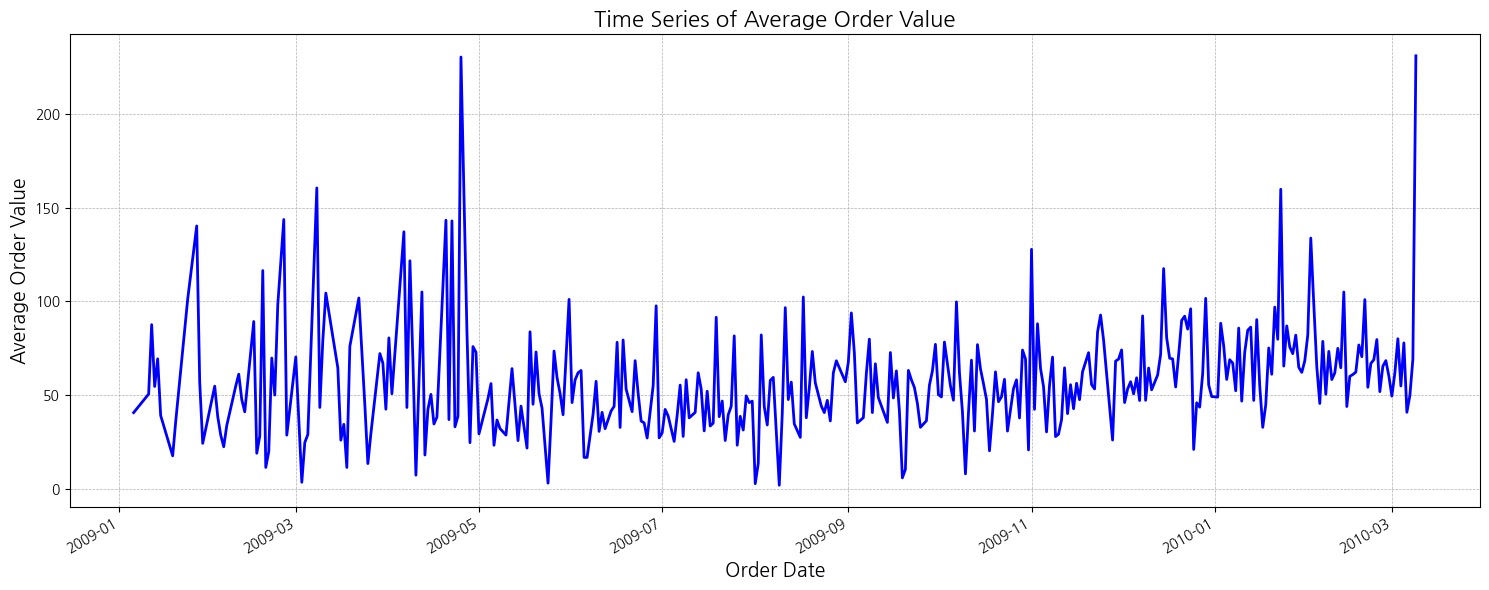

In [13]:
import matplotlib.pyplot as plt

# 평균 주문 금액 그래프 그리기
plt.figure(figsize=(15, 6))
avg_order_value['AvgOrderValue'].plot(color='blue', lw=2)
plt.title('Time Series of Average Order Value', fontsize=16)
plt.xlabel('Order Date', fontsize=14)
plt.ylabel('Average Order Value', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

2009년 1월 6일에 평균 주문 금액은 약 $40.78입니다.

2010년 3월 9일에 평균 주문 금액은 약 $230.81입니다.

이외에도 날짜별로 평균 주문 금액을 계산해봤습니다. 전체적으로 시간이 지남에 따라 평균 주문 금액의 변화 추이를 파악할 수 있습니다.

## 재구매율 분석

In [14]:
# 재구매율 분석

# 각 사용자별로 첫 구매 날짜를 확인
first_purchase_date = df.groupby('UserId')['OrderDate'].min().reset_index()
first_purchase_date.columns = ['UserId', 'FirstPurchaseDate']

# 첫 구매 데이터를 원래 데이터에 합치기
df_with_first_purchase = pd.merge(df, first_purchase_date, on='UserId')

# 첫 구매 이후의 주문을 필터링하여 재구매 주문만 추출
repurchase_data = df_with_first_purchase[df_with_first_purchase['OrderDate'] > df_with_first_purchase['FirstPurchaseDate']]

# 재구매율 계산
total_users = df['UserId'].nunique()
users_with_repurchase = repurchase_data['UserId'].nunique()

repurchase_rate = users_with_repurchase / total_users
repurchase_rate

0.5099075297225891

재구매율은 약 51.0%입니다.

이는 데이터에 포함된 전체 고객 중 약 절반 이상이 최소 한 번 이상 재구매를 했다는 것을 의미합니다. 이 값은 고객들의 로열티와 제품/서비스에 대한 만족도를 나타내는 중요한 지표입니다.

## 이탈률 분석

이탈률 분석을 진행하려면 기준이 되는 특정 시간 동안 주문을 하지 않은 사용자를 정의해야 합니다. 예를 들어, **최근 3개월 동안 주문을 하지 않은 사용자**를 '이탈 사용자'로 정의할 수 있습니다.

여기에서는 최근 3개월 동안 주문을 하지 않은 사용자를 기준으로 이탈률을 분석해보겠습니다.

1. 사용자별로 가장 최근의 주문 날짜를 파악합니다.
2. 현재 날짜와 최근 주문 날짜의 차이를 계산하여 최근 주문 이후 경과 시간을 파악합니다.
3. 경과 시간이 3개월(약 90일) 이상인 사용자를 '이탈 사용자'로 판단합니다.
4. 전체 사용자 대비 '이탈 사용자'의 비율을 계산하여 이탈률을 도출합니다.

In [15]:
from datetime import timedelta

# 가장 최근 날짜 파악
most_recent_date = df['OrderDate'].max()

# 사용자별로 가장 최근의 주문 날짜를 파악
last_order_date = df.groupby('UserId')['OrderDate'].max()

# 이탈 사용자 판별: 최근 주문 날짜와 현재 날짜의 차이가 3개월 이상인 사용자
churned_users = last_order_date[last_order_date < (most_recent_date - timedelta(days=90))].index

# 이탈률 계산
churn_rate = len(churned_users) / df['UserId'].nunique()
churn_rate

0.4438573315719947

이탈률은 약 44.4%입니다.

44.4%로 높게 나온 것은 비즈니스에 큰 문제점이 있을 수 있음을 시사합니다. 고객들이 서비스나 제품에 만족하지 않아 이탈하는 것일 수 있습니다.
이 결과를 바탕으로 원인 분석을 진행하고, 이탈하는 고객들의 특징이나 경향을 파악해야 합니다.
추가로, 이탈 위험에 처한 고객에게 특별한 프로모션, 할인, 설문조사 등을 제공하여 고객의 재구매를 자극하거나 피드백을 받아서 서비스 개선 방향을 모색할 필요가 있습니다.

## 요일별 주문 트렌드 분석

<Figure size 1000x600 with 0 Axes>

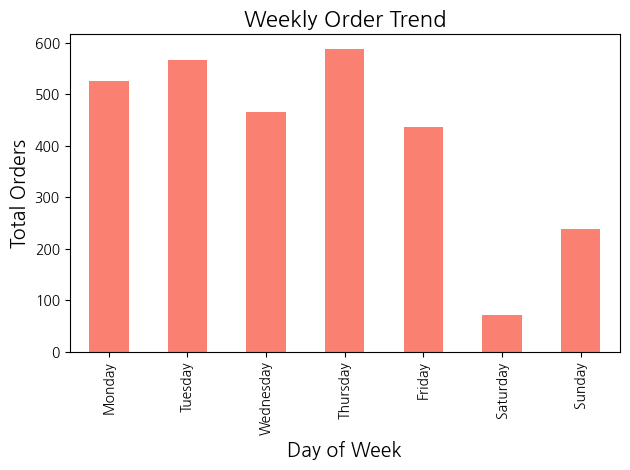

In [16]:
# 요일별 주문 트렌드 분석
df['DayOfWeek'] = df['OrderDate'].dt.day_name()
day_order = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,
             'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
weekly_orders = df.groupby('DayOfWeek').agg({'OrderId': 'nunique'}).rename(columns={'OrderId': 'TotalOrders'}).reindex(day_order.keys())

plt.figure(figsize=(10, 6))
weekly_orders.plot(kind='bar', color='salmon', legend=False)
plt.title('Weekly Order Trend', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)
plt.tight_layout()
plt.show()

## RFM 분석 (사용자 세그멘테이션)

RFM 분석은 다음과 같은 세 가지 요소를 기반으로 고객을 세그먼트화합니다:

* Recency (R): 고객이 마지막으로 구매한 날짜. (최근성)
* Frequency (F): 주어진 기간 동안 고객이 구매한 횟수. (빈도)
* Monetary (M): 주어진 기간 동안 고객이 구매한 총 금액. (금액)

In [17]:
# RFM 분석을 위한 값 계산

# Recency
most_recent_purchase = df['OrderDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('UserId').agg({
    'OrderDate': lambda x: (most_recent_purchase - x.max()).days,  # Recency
    'OrderId': 'count',  # Frequency
    'TotalCharges': 'sum'  # Monetary
})

rfm.rename(columns={
    'OrderDate': 'Recency',
    'OrderId': 'Frequency',
    'TotalCharges': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
UserId,,,
47,5,76,2934.2209
95,337,2,11.1500
98,309,10,52.9700
112,415,1,17.7600
141,117,1,30.8700


* Recency: 사용자가 마지막으로 주문한 날짜부터 지금까지의 일수입니다. 값이 낮을수록 최근에 구매한 것으로, 고객이 활발하게 활동 중임을 나타냅니다.
* Frequency: 주어진 기간 동안 사용자가 주문한 횟수입니다. 빈도가 높을수록 해당 고객이 자주 구매하는 것으로 판단할 수 있습니다.
* Monetary: 사용자가 지출한 총 금액입니다. 이 값이 높을수록 고객이 더 많은 구매를 한 것으로 판단할 수 있습니다.

In [18]:
# RFM 점수 계산

# Recency는 낮을수록 좋기 때문에 반대로 점수 부여
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# Frequency와 Monetary는 높을수록 좋기 때문에 그대로 점수 부여
rfm['F'] = np.where(rfm['Frequency'] == 1, 1, np.where(rfm['Frequency'] <= 3, 2, np.where(rfm['Frequency'] <= 5, 3, 4)))
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# RFM Segment 및 Score 계산
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

rfm.sort_values(by='RFM_Score', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
UserId,,,,,,,,
47,5,76,2934.2209,4,4,4,444,12
22722,7,12,270.8512,4,4,4,444,12
22186,3,9,303.2150,4,4,4,444,12
133525,7,8,776.4992,4,4,4,444,12
134462,2,24,1546.6357,4,4,4,444,12


* RFM_Segment: 각 RFM 값의 조합으로 생성된 문자열 값입니다. 예를 들어, "444"는 모든 카테고리에서 최고 점수를 받은 사용자를 나타냅니다.
* RFM_Score: R, F, M 값의 합계로, 최대 12점까지 가능합니다. 점수가 높을수록 가치 있는 사용자로 판단됩니다.


In [19]:
# RFM 점수에 따라 세그먼트 분류
rfm['Segment'] = 'Bronze'
rfm.loc[rfm['RFM_Score'] > rfm['RFM_Score'].quantile(0.5), 'Segment'] = 'Silver'
rfm.loc[rfm['RFM_Score'] > rfm['RFM_Score'].quantile(0.75), 'Segment'] = 'Gold'

# 결과 확인
rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].head()

,Recency,Frequency,Monetary,RFM_Score,Segment
UserId,,,,,
47,5,76,2934.2209,12,Gold
95,337,2,11.1500,4,Bronze
98,309,10,52.9700,7,Bronze
112,415,1,17.7600,3,Bronze
141,117,1,30.8700,5,Bronze


- Gold: RFM 점수가 전체 사용자의 75%보다 높은 사용자들입니다. 이들은 가장 최근에 구매한 고객 중에서 주문 빈도와 주문 금액이 높은 사용자들입니다.
- Silver: RFM 점수가 전체 사용자의 중간 50%에 해당하는 사용자들입니다. 이들은 최근에 구매한 적이 있거나, 구매 빈도나 금액이 중간 정도인 사용자들입니다.
- Bronze: RFM 점수가 전체 사용자의 하위 50%에 해당하는 사용자들입니다. 이들은 오랜 시간 동안 구매하지 않았거나, 구매 빈도나 금액이 낮은 사용자들입니다.

이렇게 세그먼트를 나누면 마케팅 팀이나 영업 팀은 각 세그먼트별로 다양한 전략을 수립하고 실행할 수 있습니다. 예를 들어, Gold 사용자들에게는 높은 가치의 프로모션을 제공하거나 특별한 혜택을 줄 수 있습니다. Silver 사용자들에게는 재구매를 유도하는 캠페인을 실행하고, Bronze 사용자들에게는 재활성화 캠페인을 수행하여 사이트나 서비스에 다시 참여하도록 유도할 수 있습니다.